In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import io
import scipy.io as sio
%matplotlib inline 
import pylab
import csv
from Tkinter import Tk
from tkFileDialog import askopenfilename
from tkFileDialog import askdirectory
import nibabel as nb
from scipy import io
#from nifti import NiftiImage
import nibabel as nb
from scipy.interpolate import interp1d
from scipy import ndimage

# Open data

In [3]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)

/media/test4/100106/100106Final/100106ss2on500cregcdFF20sMpsfkfint169Smith0_4_60TS.mat


In [4]:
Ua=sio.loadmat(filename)
DT=Ua['TSo']
DT.shape

(10608, 169)

In [4]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename2 = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename2)

/media/sophie/1554f3a2-94a1-4cf8-ae79-8a6fef1b5f7e/FreeBehaviorPanNeuronalGCaMP6/100106/100106Final/100106ss2on500cregcdFF20sMpsfkfint169Smith0_4_60IC.nii


In [5]:
img1 = nb.load(filename2)
data = img1.get_data()
S=data.shape
S

(189, 125, 10, 169)

In [6]:
S=data.shape
S

(189, 125, 10, 169)

Z-score

In [7]:
Demean=np.zeros(S)
Dmaps=np.zeros(S)
Dvar=np.zeros(S)
Var=np.zeros(S[3])
D2=np.zeros([S[0],S[1],5,S[3]])
Tvar=np.zeros(S[3])

In [8]:
for i in range(S[3]):
    Demean[:,:,:,i]=data[:,:,:,i]-np.mean(np.mean(np.mean(data[:,:,:,i],0),0),0)

In [9]:
for i in range(S[3]):
    Dsq=np.reshape(Demean[:,:,:,i],S[0]*S[1]*S[2])
    Var[i]=np.sqrt(np.var(Dsq))
    Dvar=Demean[:,:,:,i]/Var[i]
    Dmaps[:,:,:,i]=Dvar-2.5
    Tvar[i]=np.var(DT[i,:])
Dmaps[Dmaps<0]=0

# Open Masks

In [10]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenameM = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenameM)
img1 = nb.load(filenameM)
Masks = img1.get_data()
Sm=Masks.shape
Masks=np.array(Masks)

/media/sophie/1554f3a2-94a1-4cf8-ae79-8a6fef1b5f7e/FreeBehaviorPanNeuronalGCaMP6/100106/100106Registration/JFRC100106TransformedseparateLargetrimmedpsf.nii


In [11]:
filenameM='/home/sophie/LargeRegionList'
with open(filenameM) as f:
    content = f.readlines()
Names=[Line.replace('\n','').split(' ') for Line in content]
RegionName=[Names[i][1] for i in range(12)]
Num=[int(Names[i][0]) for i in range(12)]

In [12]:
RegionName

['OL',
 'VLNP',
 'VMNP',
 'AL',
 'MB',
 'LH',
 'SNP',
 'CX',
 'LX',
 'INP',
 'PENP',
 'GNG']

# Average in masks to sort components by brain region

In [13]:
Dmaps.shape

(189, 125, 10, 169)

In [14]:
M=np.zeros((S[3],13))
Mapmean=np.zeros(S[3])
MMasks=np.zeros(13)

In [15]:
for i in range(S[3]):
    Mapmean[i]=np.mean(np.mean(np.mean(Dmaps[:,:,:,i])))
    for j in range(12):
        MMasks[j]=np.mean(np.mean(np.mean(Masks[:,:,:,j])))
        if MMasks[j]:
            M[i,j]=np.mean(np.mean(np.mean(Masks[:,:,:,j]*Dmaps[:,:,:,i])))/(MMasks[j]*Mapmean[i])

In [16]:
CompMainName=S[3]*['']
CompNameAdd=np.zeros((S[3],12))
for i in range(S[3]):
    Max=np.max(M[i,:])
    I=np.argmax(M[i,:])+1
    for j in range(12):
        J=[l for l in range(12) if Num[l]==(j+1)]
        if M[i,j]>0.2*Max:
            CompNameAdd[i,J]=1
    J=[l for l in range(12) if Num[l]==I]
    if J!= []:
        CompMainName[i]=Names[np.array(J)][0]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [17]:
J

[10]

OL


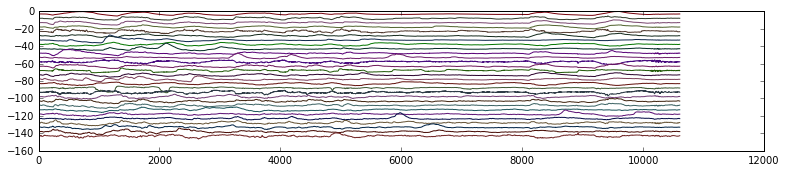

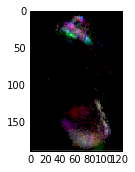

VLNP


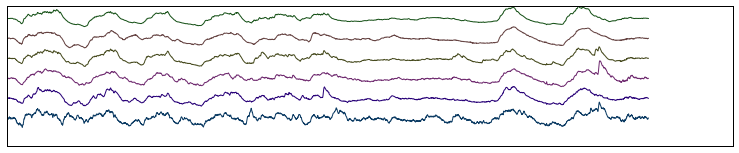

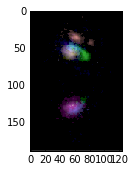

VMNP


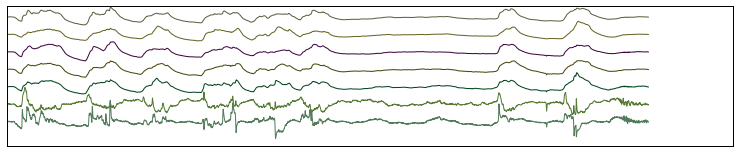

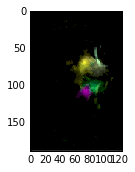

AL


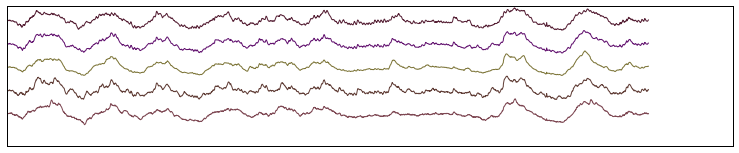

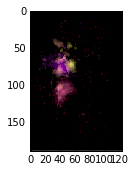

MB


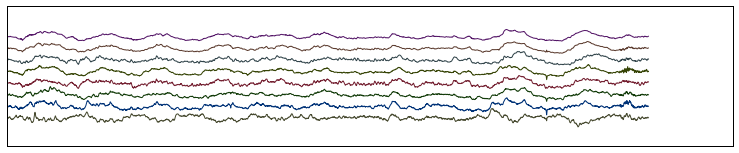

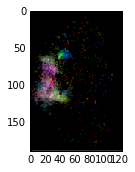

LH


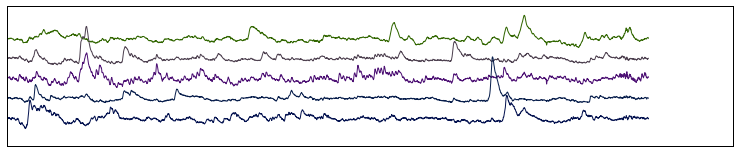

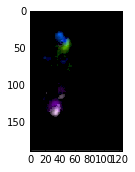

SNP


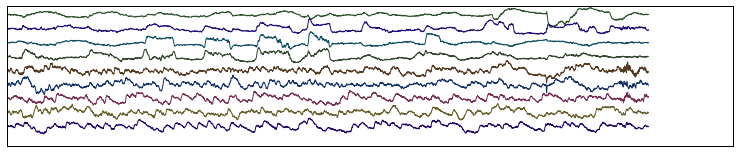

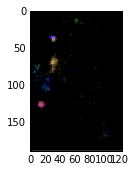

CX


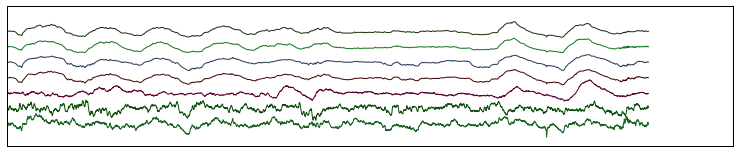

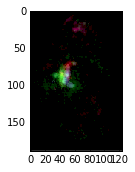

LX


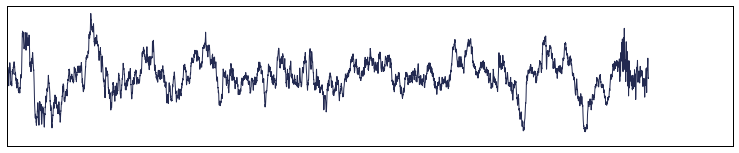

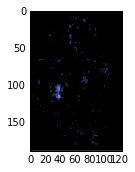

INP


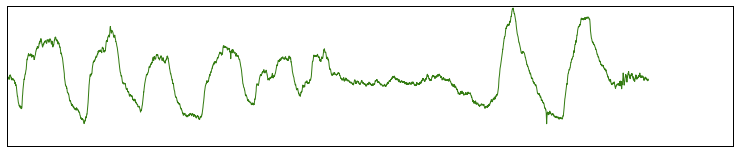

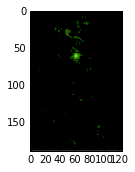

PENP


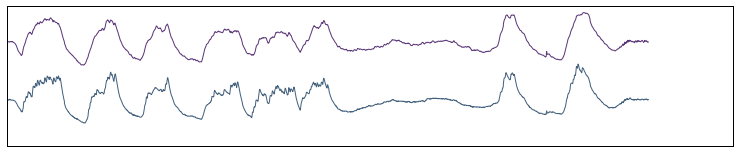

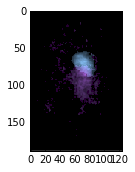

GNG


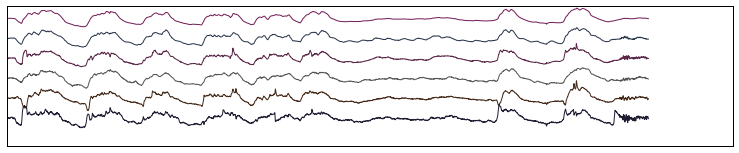

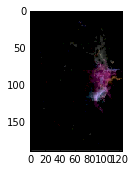

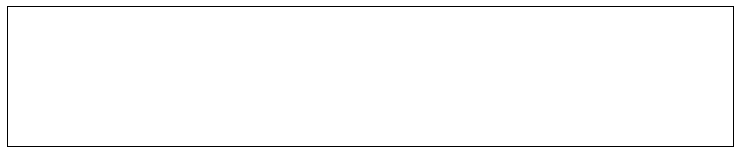

In [18]:
pylab.rcParams['figure.figsize'] = (13, 2.5)

h=5
tot=0
GoodICAnat=np.zeros(S[3])

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*C[k]/np.max(C)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            
                    
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
        


##### Looked at the components maps and time series and remove all the components which are localized on the edge of the brain and with activity unlike GCaMP6 transients.


In [26]:
BadICs=[47,62,114,54,86,149]

In [27]:
for idx in BadICs:
    GoodICAnat[idx] = 0.0

6
37
40
42
48
49
51
58
61
64
66
70
71
74
77
80
84
85
90
92
96
101
111
116
118
119
124
133
138
OL


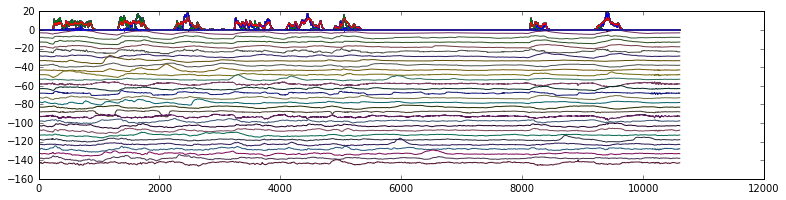

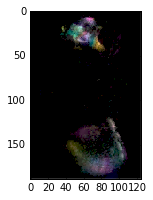

22
28
32
39
44
106
VLNP


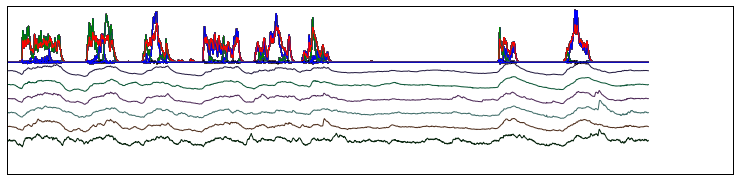

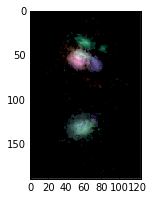

3
4
5
7
8
VMNP


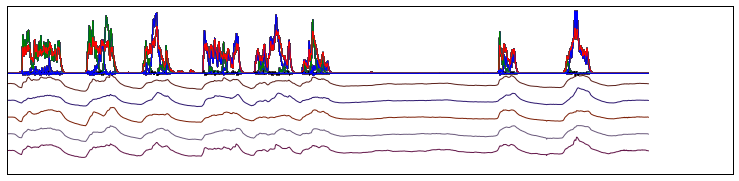

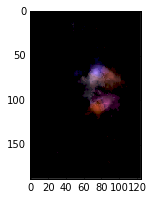

10
11
17
38
45
AL


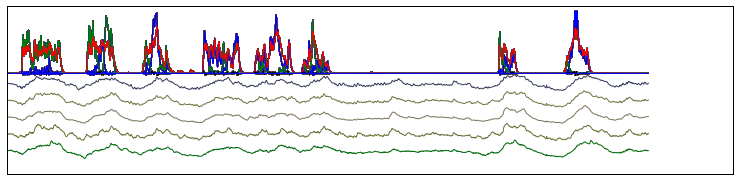

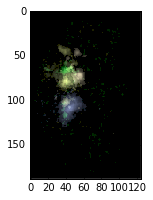

26
36
59
69
72
76
87
121
MB


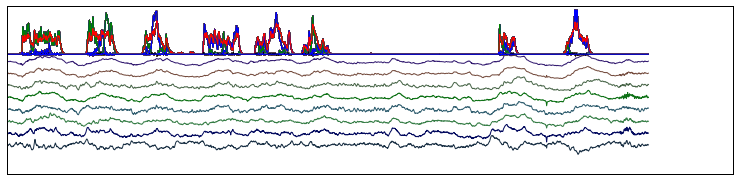

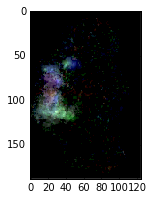

52
68
81
88
120
LH


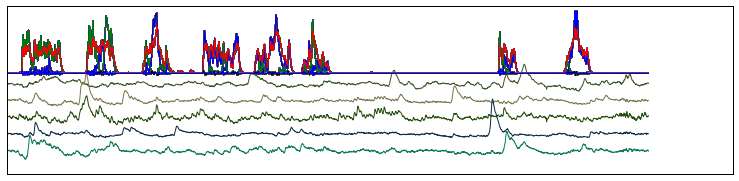

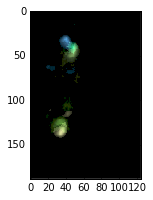

128
131
132
137
146
152
157
159
SNP


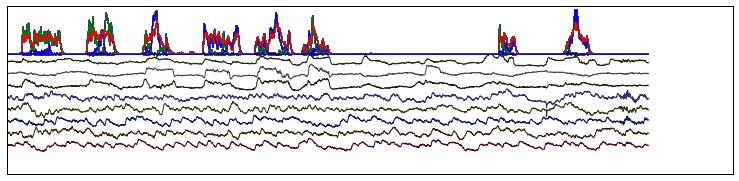

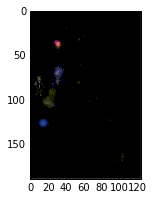

12
13
14
20
95
141
CX


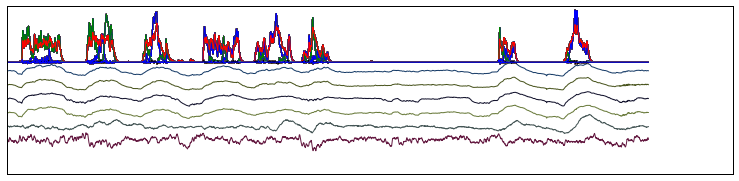

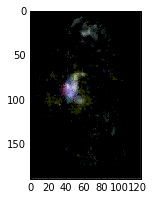

155
LX


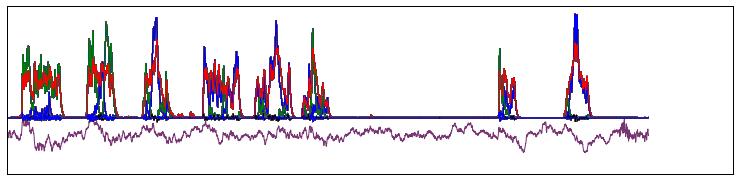

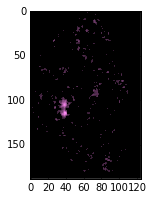

23
INP


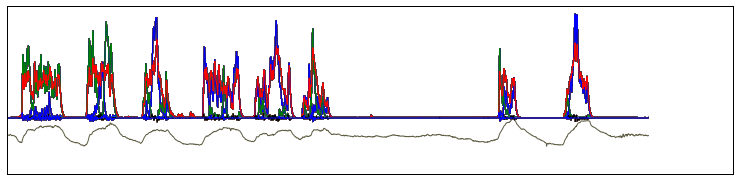

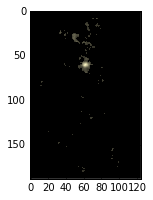

0
2
PENP


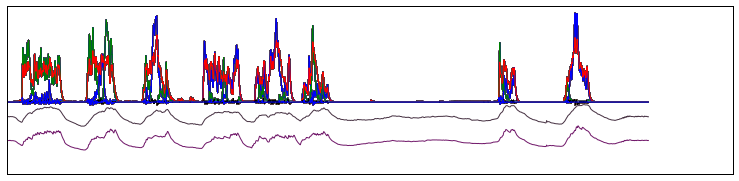

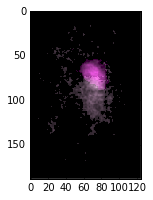

1
18
33
34
GNG


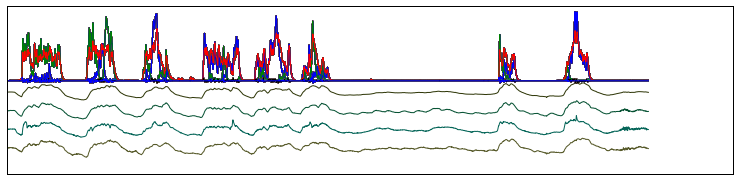

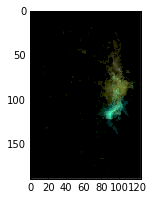

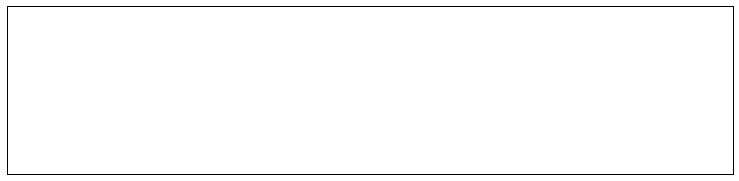

In [49]:
pylab.rcParams['figure.figsize'] = (13, 3)

h=5
tot=0
NumberInLargeRegion=np.zeros(13)

for l in range(12):
    Final_maps=np.zeros((S[0],S[1],3))
    Fmap=np.zeros((S[0],S[1],3))
    C=np.zeros(3)

    n=0
    for i in range(len(CompMainName)):                    
        Dmmv=np.mean(data[:,:,:,i],2) 
        Dmmv[Dmmv<0.2*np.max(np.max(np.max(Dmmv)))]=0
        C=np.squeeze(np.random.rand(3,1))
        labeled, nrobject=ndimage.label(Dmmv>0)
        
        if CompMainName[i]==Names[l][0] and (sum(CompNameAdd[i,:])<5) and nrobject<200 and GoodICAnat[i]==1:
            n=n+1            
            
            for k in range(3):
                Fmap[:,:,k]=0.7*Dmmv*(C[k]+0.2)/np.max(C+0.2)
            Final_maps=Final_maps+Fmap
            #plt.plot(Time_fluoICA.T,(DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            plt.plot((DT[:,i]/np.sqrt(np.var(DT[:,i]))-h*n+2),color=C/2)
            tot=tot+1
            GoodICAnat[i]=1
            print(i)
        plt.plot(Xk/5000)
        
    if n!=0:
        print(RegionName[l])
        plt.show()
        FM=Final_maps/np.max(np.max(Final_maps))
        FM[FM<0.1]=0
        plt.imshow(FM,interpolation='none')
        plt.show()
        frame1 = plt.gca()
        frame1.axes.get_xaxis().set_visible(False)
        frame1.axes.get_yaxis().set_visible(False)
                
    NumberInLargeRegion[l]=n
        

In [60]:
GoodICAnat.any()

True

In [64]:
GoodTS=DT[:,GoodICAnat==1]

In [1]:
CorrMat=np.corrcoef(GoodTS)

NameError: name 'np' is not defined

In [71]:
sio.savemat('TSforGerald.mat',{'TS':GoodTS})

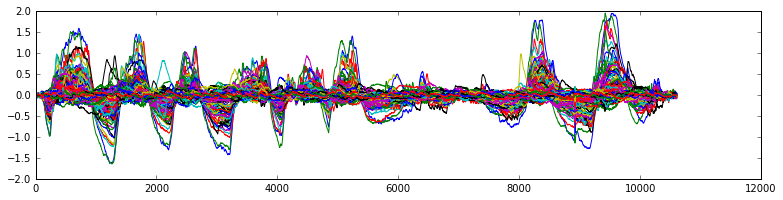

In [66]:
plt.plot(GoodTS)

In [5]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filename = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filename)
Ua=sio.loadmat(filename)
Xk=Ua['Xk']

/media/test4/100106/100106Final/100106Xk.mat


In [7]:
Xk.shape

(10608, 8)

In [10]:
import pandas as pd

In [12]:
Reg2=(Xk[:,0]-Xk[:,1])
Reg1=Xk[:,2]
pd.DataFrame(Reg1,Reg2).to_csv("Regressors.csv")

In [32]:
# from http://stackoverflow.com/questions/3579568/choosing-a-file-in-python-with-simple-dialog
from Tkinter import Tk
from tkFileDialog import askopenfilename

Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
filenamet = askopenfilename() # show an "Open" dialog box and return the path to the selected file
print(filenamet)
nimt=nb.load(filenamet)
Dtemp=np.squeeze(nimt.get_data())
Dtemp.shape

/media/sophie/1554f3a2-94a1-4cf8-ae79-8a6fef1b5f7e/FreeBehaviorPanNeuronalGCaMP6/100106/100106Registration/ICandAVG_100106ss2on500cregc.nii


(189, 125, 35)

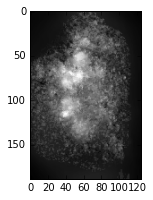

In [33]:
if S[2]>5:
    Nstack=5
    Int100=[(i+1)*100/Nstack for i in range(Nstack)]
    Percs=np.percentile(range(S[2]),Int100)
    Indices=np.split(range(S[2]),Percs)
    D1=np.zeros([S[0],S[1],Nstack])
    Dmean=np.squeeze(data[:,:,range(Nstack),2])
    for i in range(Nstack):
        Vmean=np.mean(Dtemp[:,:,Indices[i]],2)
        Dmean[:,:,i]=Vmean
else:
    Nstack=S[2]
    D1=np.zeros([S[0],S[1],S[2]])
    Dmean=data[:,:,range(S[2])]  
    Dmean=np.squeeze(Dtemp[:,:,:])

for j in range(S[3]):

    a=''
    if S[2]>5:
        for i in range(Nstack):
            V=Dmaps[:,:,Indices[i],j]
            D1[:,:,i]=np.max(V,2)
        D2[:,:,:,j]=D1
        D1[D1==0]=np.nan

plt.imshow(Dmean[:,:,1],cmap=plt.cm.gray)

In [34]:
from sklearn import linear_model

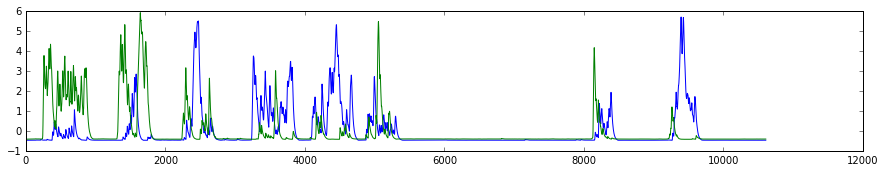

In [35]:
my_cmap=plt.cm.jet
my_cmap.set_bad(alpha=0)
Good_ICs=np.zeros(S[3])
Label_ICs=[]
pylab.rcParams['figure.figsize'] = (15, 2.5)

algorithm = linear_model.LinearRegression()

Sxk=Xk.shape

Sxk

X=np.zeros((Sxk[0],2))

X[:,0]=(Xk[:,0]-np.mean(Xk[:,0]))/np.std(Xk[:,0])
X[:,1]=(Xk[:,1]-np.mean(Xk[:,1]))/np.std(Xk[:,1])
#X[:,2]=(Xk[:,3]-np.mean(Xk[:,3]))/np.std(Xk[:,3])
#X[:,3]=(Xk[:,4]-np.mean(Xk[:,4]))/np.std(Xk[:,4])
#X[:,4]=(Xk[:,6]-np.mean(Xk[:,6]))/np.std(Xk[:,6])
#X[:,5]=(Xk[:,7]-np.mean(Xk[:,7]))/np.std(Xk[:,7])

plt.plot(X[:,0])
plt.plot(X[:,1])

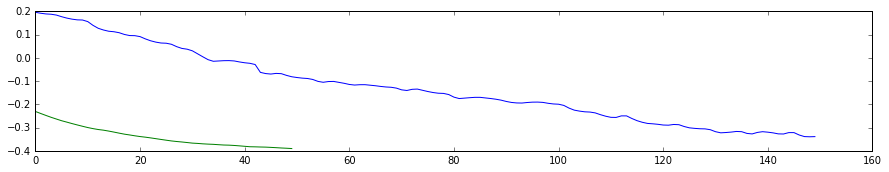

In [36]:
Rsq=np.zeros((1,S[3]))
Betas=np.zeros((2,S[3]))

X.shape

DT.shape

for j in range(S[3]):
    model = algorithm.fit(X, DT[:,j])
    Betas[:,j] = model.coef_
    Rsq[:,j] = model.score(X,DT[:,j])

plt.plot(DT[3850:4000,6])
plt.plot(X[3850:3900,1])

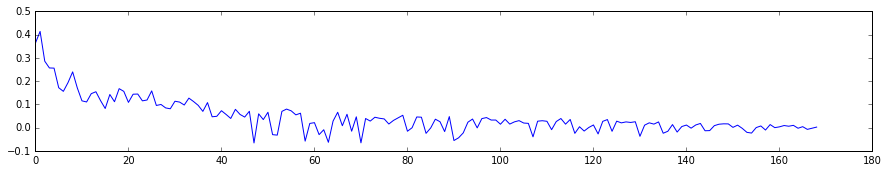

In [37]:
RsqUni=np.zeros((6,S[3]))
BetaUni=np.zeros((6,S[3]))

Sx=X.shape

for k in range(2):
    for j in range(S[3]):
        model = algorithm.fit(np.reshape(X[:,k],(Sx[0],1)), DT[:,j])
        BetaUni[k,j] = model.coef_
        RsqUni[k,j] = model.score(np.reshape(X[:,k],(Sx[0],1)),DT[:,j])
    

plt.plot(Betas[0,:])

In [38]:
import random

In [39]:
if S[2]>5:
    Final_map=np.zeros([S[0],S[1],5,3])
    Fmaps=np.zeros([S[0],S[1],5,3])
else:
    Final_map=np.zeros([S[0],S[1],3]) 
    Fmaps=np.zeros([S[0],S[1],3])    
C=np.zeros([S[3],3])
C1=np.zeros([6,3])
C1[0][:]=(1,0,0)
C1[1][:]=(0,1,0)
C1[2][:]=(0,0,1)
C1[3][:]=(0.8,0.8,0)
C1[4][:]=(0,1,1)
C1[5][:]=(1,0,1)
S1=DT.shape

In [40]:
C=np.zeros((S[3],3))
i=0
l=0
Betas2=Betas
LightNuminRegion=np.zeros(12)
for j in range(S[3]):  
    if Betas2[0,j]>0.1*np.max(Betas2[0,:]) and abs(Betas2[1,j])<0.1*np.max(Betas2[1,:]):
    #if 1>0.1:
        #C[j,:]=C1[i%6][:]
        C[j,2]=1
        C[j,1]=Betas2[0,j]/np.max(Betas2[0,:])
        #C[j,2]=1
        for k in range(3):           
            M=np.max(np.squeeze(np.reshape(D2[:,:,:,j],S[0]*S[1]*5)))
            Fmaps[:,:,:,k]=0.4*D2[:,:,:,j]*C[j,k]/M
        Final_map=Final_map+Fmaps
        #Betas[0,j]=0
        #print(Indexo[j])
        print(j+1)
        print(RegionName[int(CompMainName[j])-1])     
        LightNuminRegion[int(CompMainName[j])-1]=LightNuminRegion[int(CompMainName[j])-1]+1
        i=i+1
        l=l+1

        #if l==2:
            #break
    

79
CX
84
GNG
